# Heuristic Mixture Model for Named Entity Recognition

This notebook serves to present the implementation of a Heuristic Mixture Model for Named Entity Recognition (NER). 

**Purpose and Scope:** This notebook presents a detailed exploration and implementation of a heuristic mixture model aimed at enhancing Named Entity Recognition (NER) capabilities. Named Entity Recognition is a crucial task in the field of Natural Language Processing (NLP) that involves identifying and classifying key information in text into predefined categories such as names of people, organizations, locations, etc.

**Goal:** The primary goal of this notebook is to implement a Heuristic Mixture Model for Named Entity Recognition. The model is designed to leverage the strengths of both rule-based and machine learning approaches to approximate the overall performance of more sophisticated NER systems while maintaining full interpretability and transparency.

**Approach:** The approach involves heavy feature engineering and the creation of a custom dataset to train the model. The model is then evaluated on a test set to assess its performance.

An overview of the notebook is as follows:

**NoteBook Overview:**
1. [Introduction](#1-introduction)
    * [Other Approaches](#11-other-approaches)
    * [Knowledge from EDA](#12-knowledge-from-eda)
2. [Data Preprocessing](#2-data-preprocessing)
3. [Feature Engineering](#3-feature-engineering)
    * [Dataset Feature building](#data-building)
    * [Feature Engineering](#preceeding-words-analysis-on-xtrain)
    * [Creating Dataframes](#creating-dfs)
4. [Modeling](#4-modeling)
5. [Evaluation](#5-evaluation)
6. [Conclusion](#6-conclusion)


# 1. Introduction

Named Entity Recognition (NER) is a fundamental task in Natural Language Processing (NLP) that involves identifying and classifying named entities in text into predefined categories such as names of people, organizations, locations, etc. NER is essential for various NLP applications, including information extraction, question answering, and sentiment analysis. In this project we are using data provided by the kaggle competition. There exist a myriad of approaches to NER, ranging from rule-based systems to machine learning models. Each approach has its strengths and weaknesses, and combining them can lead to improved performance. We will in this notebook attempt to implement a heuristic driven mixture model for NER that combines rule-based feature engineering and machine learning approaches to enhance the overall performance of the NER system on the given dataset.

## 1.1 Other Approaches

There are several approaches to Named Entity Recognition (NER), with some of the [most common](https://www.analyticsvidhya.com/blog/2021/11/a-beginners-introduction-to-ner-named-entity-recognition/#:~:text=There%20are%20four%20different%20NER,based%2C%20and%20deep%20learning%20approaches.) ones being:

1. **Rule-Based Systems:** Rule-based systems rely on handcrafted rules to identify named entities in text. These rules are typically based on patterns, regular expressions, and dictionaries. While rule-based systems can be effective in capturing specific patterns, they may lack generalization and struggle with complex contexts.

2. **Dictionary-Based Systems:** Dictionary-based systems use predefined dictionaries of named entities to identify entities in text. These dictionaries can be curated manually or extracted from external sources. While dictionary-based systems are effective for recognizing known entities, they may struggle with out-of-vocabulary words and entities.

3. **Machine Learning Models:** Machine learning models, such as Conditional Random Fields (CRFs), RNNs and Bidirectional LSTMs, have been widely used for NER. These models learn to identify named entities from labeled data and can capture complex patterns and contexts. However, they require large amounts of annotated data for training and may struggle with rare or unseen entities.

4. **Deep Learning Models:** Deep learning models, such as BERT, GPT, and RoBERTa, have shown state-of-the-art performance in NER tasks. These models leverage pre-trained language representations to capture rich semantic information and context. However, they are computationally expensive and require large amounts of data for training.

The 4. approach has been implemented in our notebook deberta.ipynb, which we can use to compare the performance of the heuristic mixture model with the deep learning model.

## 1.2 Knowledge from EDA

From our extensive exploratory data analysis (EDA) in the previous notebook, we gained valuable insights into the dataset. Some of the key findings included:

- Position and length of the words in the sentence play a crucial role in determining whether a word is a named entity, and what type of entity it is.
- The context of the words, such as the words that precede and follow them, can provide valuable information for identifying named entities.
- There is a class imbalance in the dataset, with the majority of words being classified as 'O' (non-entity). Furhtermore, the PCA analysis showed that the hardest problem most likely is to distinguish names from 'O' words.
- We see a clear pattern in the data, where emails, ids and urls follow a specific pattern, which can be used to identify them.

Given these insights, we can leverage the positional information, context, and patterns in the data to design a heuristic mixture model for NER that combines rule-based and machine learning approaches to improve performance.

# 2. Data Preprocessing

This section will briefly cover the data preprocessing steps that were performed in the previous notebook. Since the data is already preprocessed from the kaggle competition, we will not perform any additional preprocessing in this notebook.

Firstly, we load the required libraries and the data.

In [43]:
import json
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
from names_dataset import NameDataset
from tqdm import tqdm
from spacy.tokenizer import Tokenizer
import spacy
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
# nlp = spacy.load("en_core_web_sm")
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_model = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

In [46]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

We check how the data is structured. Note that each row contains the full text and then arrays of the tokens, trailling_whitespace and labels.

In [47]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


# 3. Feature Engineering

From our Exploratory Data Analysis (EDA), we observed that the dataset is imbalanced, with the majority of tokens labeled as 'O' (Outside Named Entity). This imbalance can pose a challenge for training machine learning models, as they may struggle to learn from the limited number of positive examples. To address this issue, we will perform extensive feature engineering to extract relevant features that can help the model distinguish between named entities and non-entities. From our EDA we found the distribution:

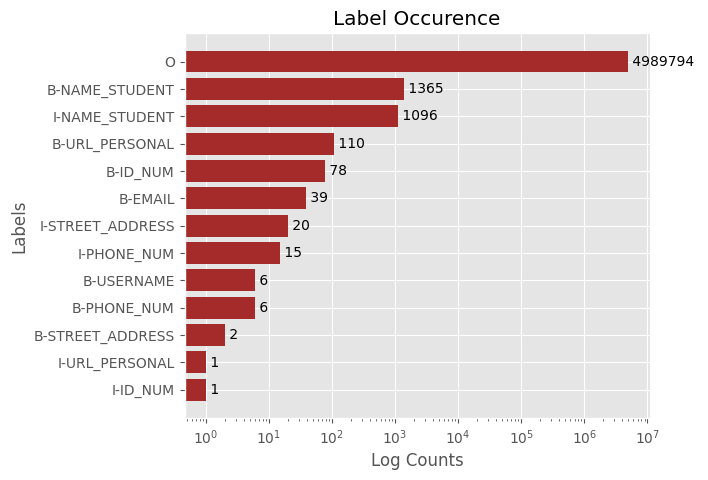

Furthermore, from the EDA we saw how different labels are represented in the data. From the BIO format we get a fragmented version of the original text labels. An example of this is how adresses are represented in different 'bites' of the original address. This makes a 'simple' model much harder to implement.

For creating regex features, we experiment with different regex patterns and tune it to have the highest precision. We can see that the regex features are very useful in identifying the different types of PII.

In [48]:
reg = r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
b_ids = df.labels.explode().str.contains('I-STREET_ADDRESS')
specific_id = b_ids.loc[b_ids]
ids_in_tokens = df.tokens.explode().str.contains(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  20
Regex finding Ids in all tokens:  246

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 4.927358517209601e-05


Using above method for choosing regex patterns, we can create a set of regex patterns that can be used to identify different types of PII in the text. We can then use these regex patterns to create features that can help the model identify named entities more accurately.

## Model Definition
Our objective is to construct a model characterized by simplicity and efficiency. This model will scrutinize each token within a string, subjecting it to a series of evaluative functions. Should any of these functions affirmatively identify a token as significant, that token is then designated as a keyword. Subsequently, the model outputs both the keyword and its corresponding index within the input string.

The PiiModel class has been meticulously designed to analyze text data for the purpose of identifying personally identifiable information (PII) and other significant tokens. Employing a robust amalgamation of regular expression (regex) patterns, named entity recognition (NER) techniques, and tailored heuristics, the model adeptly pinpoints and extracts critical personal details such as names, email addresses, and phone numbers. By integrating these components, the model employs a sophisticated mixture of methods to effectively recognize and classify various types of significant information embedded within text data.

Features generated by PiiModel:
- **Token Features:** Each token is analyzed to determine if it fits certain patterns such as emails, phone numbers, addresses, personal IDs, and URLs.
- **Name Analysis:** Checks if tokens are recognized as first or last names based on a given dataset with country-wise name rankings and thresholds.
- **Punctuation Marks:** Identifies whether a token is a punctuation mark.
- **Capitalization:** Determines if a token starts with an uppercase letter.
- **Numerical Analysis:** Calculates the percentage of numeric characters in a token.
- **Word Length:** Measures the length of each token.
- **Stop Words:** Flags tokens that are common stop words.
- **Contextual Named Entity Recognition (NER):** Analyzes the text for entities like persons and locations, contextual to the token being analyzed.
- **Windowed Neighboring Features:** For each token, checks surrounding tokens up to five positions away to the left and right for all aforementioned features.
- **Contextual Precedence Check:** For significant tokens related to specific labels, checks if preceding tokens (up to two positions before) are significant for that label.

Data Frame Building: Structures all tokens into a DataFrame with corresponding labels and features, allowing for easy manipulation and analysis.

We added an extra dataset to the model in the form of the [names_dataset](https://pypi.org/project/names-dataset/) python module. The Python library provides information about names:

* Popularity (rank)
* Country (105 countries are supported)
* Gender

And is composed of 730K first names, 983K last names - extracted from the [Facebook massive dump (533M users)](https://www.theguardian.com/technology/2021/apr/03/500-million-facebook-users-website-hackers).

In [49]:
names = NameDataset()

We can visually check the output of the names_dataset module:

In [50]:
names.first_names.get("August")

{'country': {'AT': 0.071,
  'BE': 0.044,
  'DE': 0.059,
  'DK': 0.052,
  'MY': 0.052,
  'NL': 0.071,
  'SA': 0.047,
  'SE': 0.069,
  'US': 0.341,
  'ZA': 0.195},
 'gender': {'F': 0.141, 'M': 0.859},
 'rank': {'AT': 351,
  'BE': 1628,
  'DE': 1997,
  'DK': 248,
  'MY': 6402,
  'NL': 1910,
  'SA': 14254,
  'SE': 306,
  'US': 2869,
  'ZA': 2723}}

In [51]:
import re

class PiiModel:
    def __init__(self, text: str = None, 
                 names_dataset = None, tokens: list = None, 
                 significant_tokens: dict = None, 
                 dataframe: pd.DataFrame = None, full_text: str = None):
        self.text = text
        self.names = names_dataset
        self.tokens = tokens
        self.name_rank_threhsold = 1500
        self.country_threshold = 0.01
        self.significant_tokens = significant_tokens
        self.feature_df = pd.DataFrame()
        self.input_df = dataframe
        self.full_text = full_text
        pass
    
    def get_firstname(self, name: str) -> bool:
        found_name = self.names.first_names.get(name.capitalize())

        if not found_name:
            return False
        country = found_name["country"]
        # If any of the countries has a higher percentage than the threshold and the rank is lower than the threshold
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False

    
    def get_lastname(self, lastname: str) -> bool:
        found_name = self.names.last_names.get(lastname.capitalize())
        # we check if the max country is higher than a threshold then we say it is a valid name
        if not found_name:
            return False
        country = found_name["country"]
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False
    
    def get_email_regex(self):
        return r'[\w\.-]+@[\w\.-]+'
    
    def get_phone_number_regex(self):
        return r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    
    def get_address_regex(self):
        return r'\d{1,5}\s\w.\s(\b\w*\b\s){1,2}\w*\.'
    
    def get_personal_id_regex(self):
        return r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
    
    def get_url_personal_regex(self):
        return r'https?://[\w\.-]+'
    
    def numb_percent(self, text: str) -> float:
        return sum(c.isdigit() for c in text) / len(text)
    
    def word_length(self, text: str) -> int:
        return len(text)
    
    def is_punctuationmark(self, text: str) -> bool:
        return text in [".", ",", "!", "?", ";", ":"]
    
    def stop_words(self, text: str) -> bool:
        return text in nlp.Defaults.stop_words
    
    def capitalize(self, text: str) -> bool:
        return text[0].strip().isupper()
    
    def NER_ingest(self, text: str):
        return ner_model(text)

    def contextual_ner_person(self, text: str) -> bool:
        return text in list(self.NER_persons)
    
    def contextual_ner_location(self, text: str) -> bool:
        return text in (self.NER_locations)
    
    def check_preceding_contextual_tokens(self, index, label):
        # Extract relevant tokens directly, avoiding repeated DataFrame row access
        start_index = max(0, index-2)
        tokens_to_check = self.feature_df['token'][start_index:index]
        
        # Get the set of significant tokens for the label, defaulting to an empty set if not found
        significant_tokens_set = self.significant_tokens.get(label, set())
        
        # Check if any of the tokens to check are in the significant tokens set
        return any(token in significant_tokens_set for token in tokens_to_check)

    
    def build_df(self, text: str = "", tokens: list = None, labels: list = None) -> pd.DataFrame:
        token_indices = self.tokens
        if not self.tokens and text != "":
            token_indices = self.tokenizer(text)
            self.tokens = token_indices
        if tokens:
            token_indices = tokens
        elif self.input_df is not None:
            token_indices = self.input_df["tokens"]
        self.feature_df["token"] = token_indices

        self.feature_df['labels'] = labels
        return None

    def build_features(self) -> list[tuple[int, str]]:
        # Computing Features
        self.feature_df['first_name'] = self.feature_df['token'].apply(self.get_firstname)
        self.feature_df['last_name'] = self.feature_df['token'].apply(self.get_lastname)
        self.feature_df['email'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_email_regex(), x)))
        self.feature_df['phone_number'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_phone_number_regex(), x)))
        self.feature_df['address'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_address_regex(), x)))
        self.feature_df['personal_id'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_personal_id_regex(), x)))
        self.feature_df['url'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_url_personal_regex(), x)))
        self.feature_df['capitalized'] = self.feature_df['token'].apply(lambda x: self.capitalize(x))
        self.feature_df['numb_percent'] = self.feature_df['token'].apply(self.numb_percent)
        self.feature_df['word_length'] = self.feature_df['token'].apply(self.word_length)
        self.feature_df['norm_index'] = self.feature_df.index / len(self.feature_df)
        self.feature_df['is_punctuation'] = self.feature_df['token'].apply(self.is_punctuationmark)
        self.feature_df['stop_word'] = self.feature_df['token'].apply(self.stop_words)

        ingested = self.NER_ingest(self.full_text)

        self.NER_persons = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'PER']).explode().reset_index(drop=True)
        self.NER_locations = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'LOC']).explode().reset_index(drop=True)

        self.feature_df['contextual_ner_person'] = self.feature_df['token'].apply(self.contextual_ner_person)
        self.feature_df['contextual_ner_location'] = self.feature_df['token'].apply(self.contextual_ner_location)

        # Window
        for i in range(1, 6):
            self.feature_df[f'r_neighboured_email_{i}'] = self.feature_df['email'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_email_{i}'] = self.feature_df['email'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_address_{i}'] = self.feature_df['address'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_address_{i}'] = self.feature_df['address'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_url_{i}'] = self.feature_df['url'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_url_{i}'] = self.feature_df['url'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(i).fillna(False)


        if self.input_df is not None:
            self.feature_df["text_index"] = self.input_df.text_index
        # Add a new feature for each label based on contextual tokens
        for label in self.significant_tokens.keys():
            feature_name = f'{label.lower()}_contextual_presence'
            self.feature_df[feature_name] = [self.check_preceding_contextual_tokens(i, label) for i in range(len(self.feature_df))]


        return None


With the model defined, we can then move on to building the dataset and training the model.

## Data building
We can then start building the data for the model. We will split the data into training and testing data. We will then use the PiiModel class to generate the features for the data.

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_split = df

X_train, X_test, y_train, y_test = train_test_split(df_split, 
                                                    df_split.labels, 
                                                    test_size=0.33, 
                                                    random_state=42)

### Preceeding Words analysis on Xtrain:

From the EDA, and as mentioned in [Knowledge from EDA](#12-knowledge-from-eda), we know that the preceeding words are very important in determining the type of PII. For example, if the word 'email' is present in the preceeding words, the token is most likely an email. We can use this information to create a feature that checks for the presence of certain words in the preceeding words. This mechanism is an aggresively simplified version of what the attention mechanism in transformers does.

Firstly, we create the initial dataframes of the training data.

In [127]:
dfs_analysis = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    model.build_df(tokens=tokens, labels=labels)
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_analysis.append(model.feature_df)

X_analysis = pd.concat(dfs_analysis, axis=0)
X_analysis.fillna(0, inplace=True)


  0%|          | 0/4560 [00:00<?, ?it/s]

100%|██████████| 4560/4560 [00:02<00:00, 1656.87it/s]


In [128]:
_analysis_df = X_analysis[['token', 'labels']].reset_index()

In [129]:
_analysis_df.labels.unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-ID_NUM',
       'B-URL_PERSONAL', 'B-EMAIL', 'B-USERNAME', 'I-URL_PERSONAL',
       'I-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS'], dtype=object)

We can then define a "window" of N words to look at in the preceeding words. We can then create a feature that checks for the presence of certain words in the preceeding words.

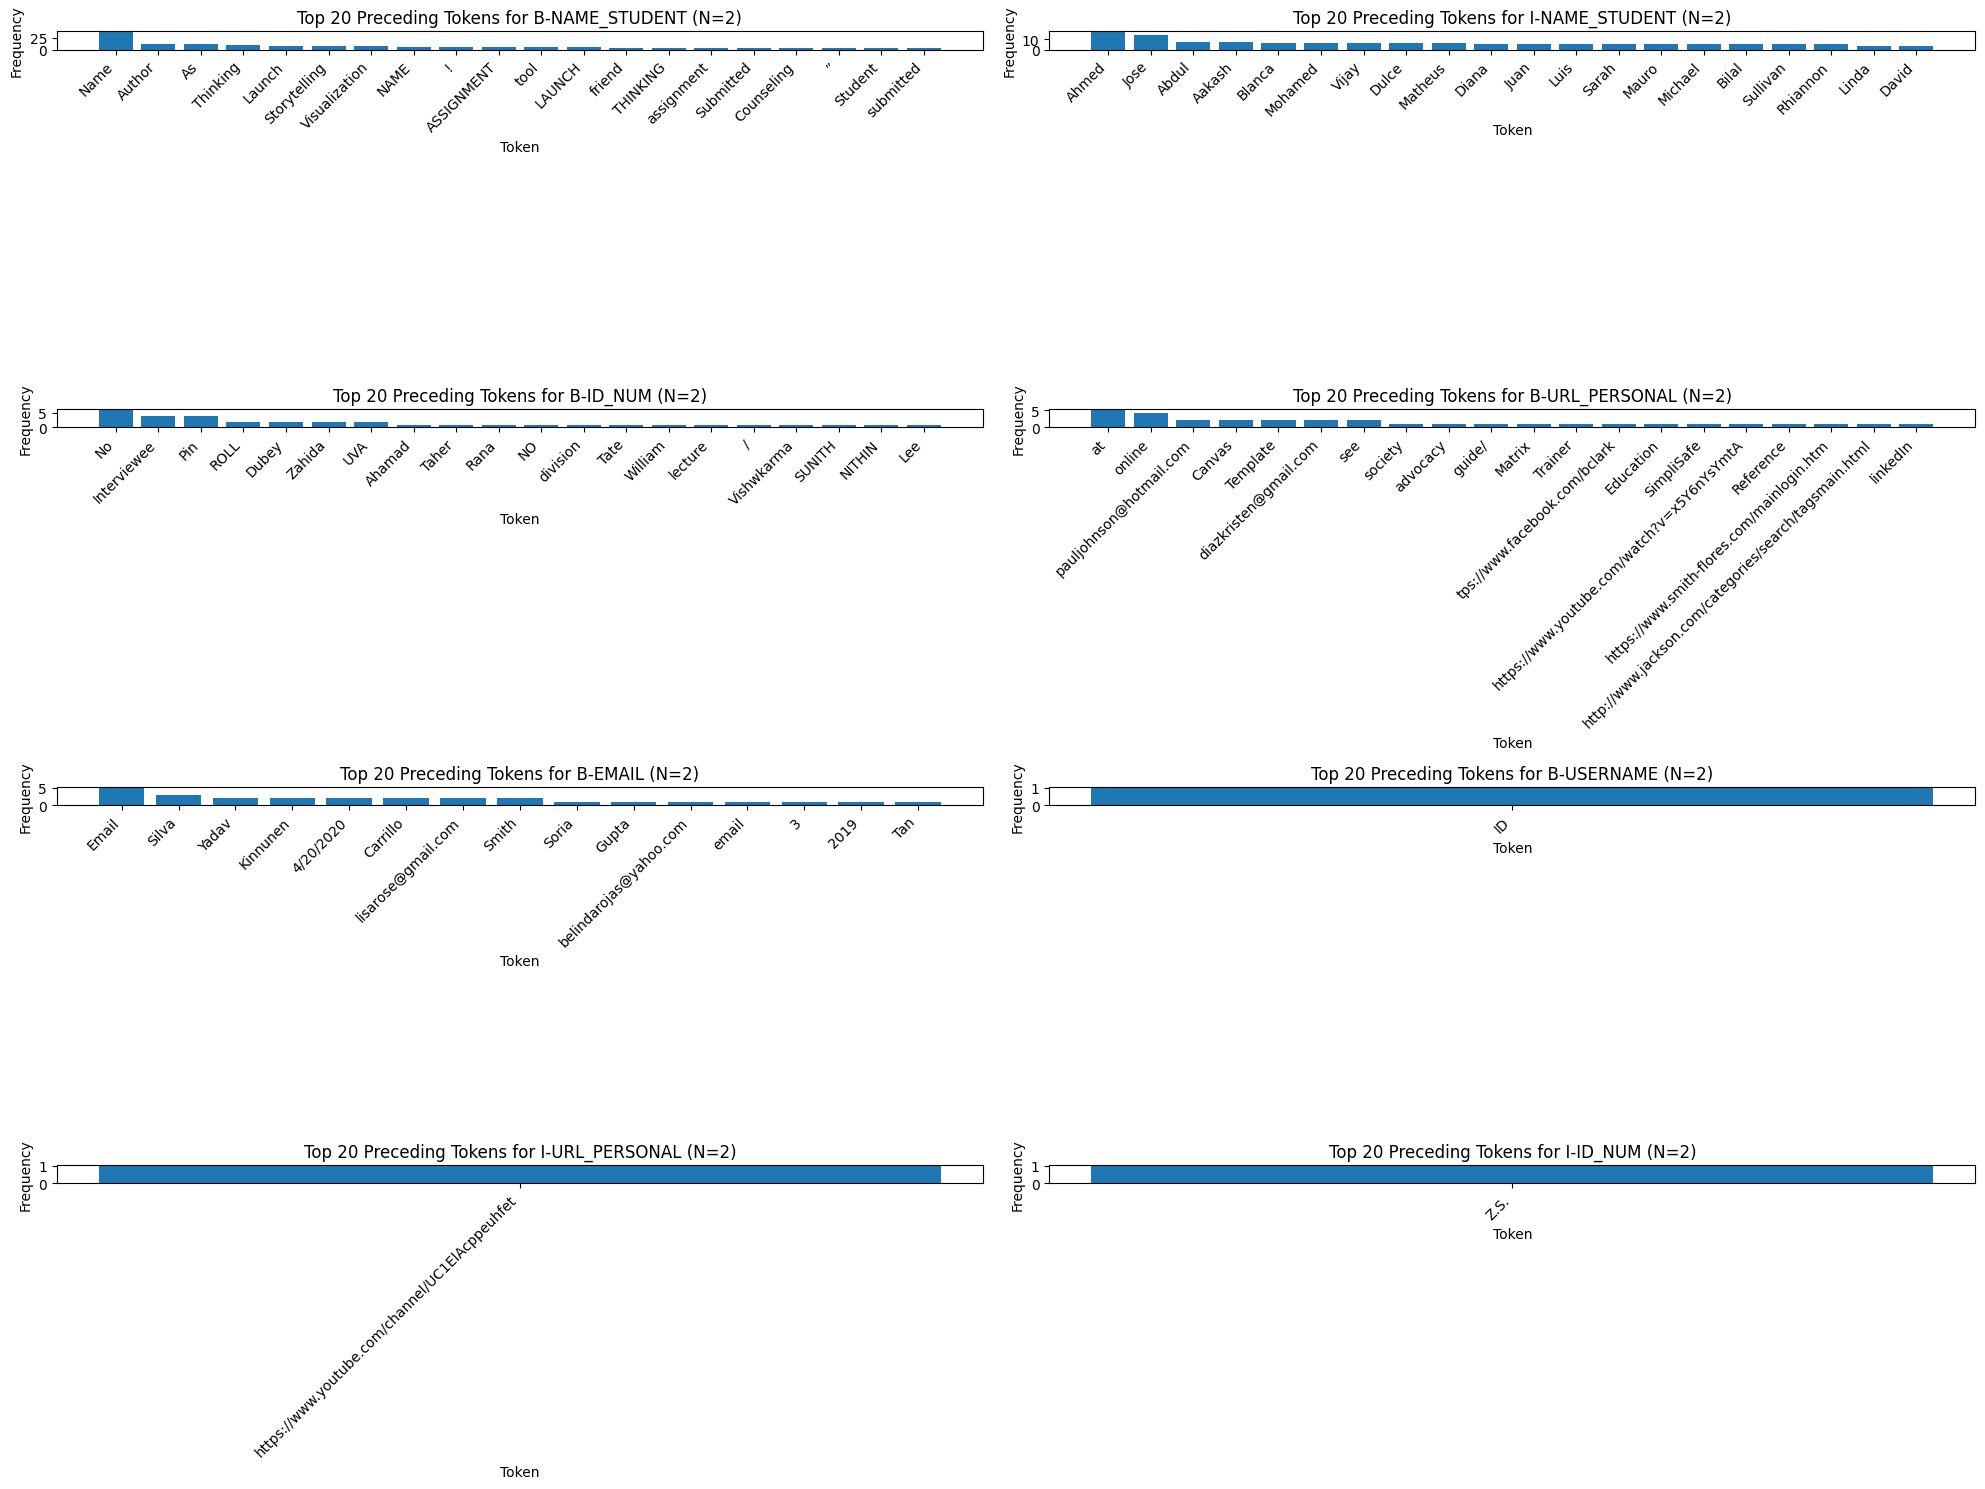

In [130]:
def get_preceding_tokens(row_index, N, dataframe):
    # Calculate the start index to avoid negative indexing
    start_index = max(0, row_index - N)
    # Extract preceding N tokens, if the row_index is not at the very beginning
    if start_index < row_index:
        return dataframe.iloc[start_index:row_index]['token'].tolist()
    else:
        return []


N = 2  # Example: Look 2 tokens back
labels_of_interest = ['B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-ID_NUM',
       'B-URL_PERSONAL', 'B-EMAIL', 'B-USERNAME', 'I-URL_PERSONAL',
       'I-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS']

# Initialize a dictionary to hold token frequencies for each label
token_frequencies_by_label = {label: {} for label in labels_of_interest}

for label in labels_of_interest:
    # Filter rows for the specific label
    label_indices = _analysis_df[_analysis_df['labels'] == label].index
    
    # Collect preceding tokens for each occurrence of the label
    for index in label_indices:
        preceding_tokens = get_preceding_tokens(index, N, _analysis_df)
        for token in preceding_tokens:
            if token in token_frequencies_by_label[label]:
                token_frequencies_by_label[label][token] += 1
            else:
                token_frequencies_by_label[label][token] = 1


from collections import defaultdict

# This dictionary will count the occurrences of each token across labels
token_occurrences_across_labels = defaultdict(int)

# Count occurrences of each token across different labels
for label, frequencies in token_frequencies_by_label.items():
    for token in frequencies.keys():
        token_occurrences_across_labels[token] += 1

# Identify tokens that appear in more than one label's frequency dictionary
common_tokens = {token for token, count in token_occurrences_across_labels.items() if count > 1}


# Remove common tokens from each label's frequency dictionary
filtered_token_frequencies_by_label = {
    label: {token: frequency for token, frequency in frequencies.items() if token not in common_tokens}
    for label, frequencies in token_frequencies_by_label.items()
}


plt.figure(figsize=(20, 15))

for i, (label, frequencies) in enumerate(filtered_token_frequencies_by_label.items(), 1):
    # Sort the frequencies dictionary by value and get the top 20 tokens
    try:
        top_tokens = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
        tokens, counts = zip(*top_tokens)  # Unzip the token-count pairs
        
        # Plot
        plt.subplot(4, 2, i)  # Adjust grid size based on the number of labels
        plt.bar(tokens, counts)
        plt.title(f'Top 20 Preceding Tokens for {label} (N={N})')
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Frequency')
        plt.xlabel('Token')
    except:
        pass
    
plt.tight_layout()
plt.show()

### Creating DFs
Moving on, we can then create the dataframes for the training and testing data. We can then use these dataframes to train the model.

**OBS** these take a long time to build. So we have provided the precomputed dataframes.

In [ ]:
# if X_train.csv exists, we load it
try:
    X_train = pd.read_csv('.data/processed/X_train.csv')
except:
    dfs_analysis = []

    for i in tqdm(range(X_train.shape[0])):
        tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
        model = PiiModel(text=tokens, names_dataset=names)
        model.build_df(tokens=tokens, labels=labels)
        model.build_features()
        # Reset index and drop the old index to ensure unique indices
        model.feature_df.reset_index(drop=True, inplace=True)
        # drop duplicate columns
        model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]

        # Append the DataFrame to the list
        dfs_analysis.append(model.feature_df)

    X_train = pd.concat(dfs_analysis, axis=0)
    X_train.fillna(0, inplace=True)
    X_train.to_csv('X_train.csv', index=False)

In [ ]:
try:
    X_test = pd.read_csv('.data/processed/X_test.csv')
except:
    dfs_analysis = []

    for i in tqdm(range(X_test.shape[0])):
        tokens, labels = X_test.tokens.iloc[i], y_test.iloc[i]
        model = PiiModel(text=tokens, names_dataset=names)
        model.build_df(tokens=tokens, labels=labels)
        model.build_features()
        # Reset index and drop the old index to ensure unique indices
        model.feature_df.reset_index(drop=True, inplace=True)
        # drop duplicate columns
        model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]

        # Append the DataFrame to the list
        dfs_analysis.append(model.feature_df)

    X_test = pd.concat(dfs_analysis, axis=0)
    X_test.fillna(0, inplace=True)
    X_test.to_csv('X_test.csv', index=False)

In [133]:
# Find unique entries in y_test
X_test['labels'].unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL',
       'B-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-PHONE_NUM',
       'I-PHONE_NUM', 'B-EMAIL', 'B-USERNAME'], dtype=object)

In [148]:
# Save to file
# X_train.to_csv('.data/processed/X_train.csv')
# X_test.to_csv('.data/processed/X_test.csv')

# 4. Modeling

In this project we use the Random Forest Classifier to classify the tokens. We can then train the model and evaluate it on the test data.


In [134]:
from sklearn.metrics import fbeta_score

model = RandomForestClassifier(random_state=69,
                            n_estimators=100,
                            min_samples_split=4,
                            max_depth=15,
                            class_weight='balanced_subsample',
                            n_jobs=-1)

model.fit(X_train.drop(columns=['token', 'labels']), y_train.explode())

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       min_samples_split=4, n_jobs=-1, random_state=69)

For hyperparameter estimation we chose to stick to a defualt model. This is mostly due to the fact that hyperparameter tuning is very computationally expensive and we are not sure if the model will perform much better with hyperparameter tuning. We can then train the model and evaluate it on the test data.

# 5. Evaluation

For evaluation of the model we will use the following metrics:
- Accuracy (With 'O' labels)
- Accuracy (Without 'O' labels)
- F5 score (With 'O' labels)
- F5 score (Without 'O' labels)

The kaggle competition uses the F5 score fore evaluation. The F5 score is defined as:
$$
F_\beta=\frac{1+\beta^2}{\frac{\beta^2}{\text { Recall }}+\frac{1}{\text { Precision }}}
$$
    
Where $\beta=5$. The F5 score is a weighted average of the precision and recall, where an increase in the weight of recall is achieved by increasing the value of $\beta$. The F5 score is a useful metric for imbalanced datasets, as it places more emphasis on recall, which is crucial for identifying rare entities.

The `model.score` method is a [built in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score) method that calculates the accuracy of the model. We can then use this method to calculate the accuracy of the model.

In [135]:
# We generate some predictions
predictions = pd.Series(model.predict(X_test.drop(columns=["token", "labels"])))

In [136]:
# Sklearn accuracy of the model
model.score(X_test.drop(columns=["token", "labels"]), y_test.explode())

0.9993511394064588

In [137]:
# F5 score of the model
fbeta_score(y_test.explode(), predictions, average='micro', beta=5)

0.9993511394064588

We quickly check the distribution of predicted labels in the test data. We look for a distribution that is similar to the training data.

In [138]:
pd.Series(predictions).value_counts()

O                   1651973
B-NAME_STUDENT         1039
I-NAME_STUDENT          576
B-URL_PERSONAL           50
B-ID_NUM                 19
B-EMAIL                   9
I-STREET_ADDRESS          2
Name: count, dtype: int64

In [139]:
pd.Series(y_test.explode()).value_counts()

labels
O                   1652726
B-NAME_STUDENT          454
I-NAME_STUDENT          379
B-URL_PERSONAL           43
B-ID_NUM                 24
I-PHONE_NUM              15
I-STREET_ADDRESS         10
B-EMAIL                   9
B-PHONE_NUM               6
B-STREET_ADDRESS          1
B-USERNAME                1
Name: count, dtype: int64

It seems that our predictions are somewhat similar to the true labels. Albeit, we see that it seems to fall short in some categories.

In [140]:
df_results = pd.DataFrame({"predictions": pd.Series(predictions).reset_index(drop=True), 
                           "labels": y_test.explode().reset_index(drop=True), 
                           "tokens": X_test.token.explode().reset_index(drop=True)})
df_results.head()

,predictions,labels,tokens
0,O,O,Assignment
1,O,O,:
2,O,O,Mindmapping
3,O,O,\n\n
4,O,O,Challenge


We can then calculate an accuracy score for the model. In the accuracy metric we disregard the 'O' labels as they are the most common and can skew the results.

In [141]:
accuracy = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O")) & 
    (df_results['predictions'] == df_results['labels'])
].shape[0] / df_results[(df_results['predictions'] != "O") | (df_results['labels'] != "O")].shape[0]

In [142]:
accuracy

0.4215633423180593

**Prediction Pairs**

We can investigate further by looking at the prediction pairs. This visualises the distribution of the predicted labels compared to the true labels.

In [143]:
df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))][["predictions", "labels"]].value_counts()

predictions       labels          
B-NAME_STUDENT    O                   655
                  B-NAME_STUDENT      384
I-NAME_STUDENT    I-NAME_STUDENT      348
                  O                   228
O                 B-NAME_STUDENT       70
                  I-NAME_STUDENT       31
B-URL_PERSONAL    O                    27
                  B-URL_PERSONAL       23
O                 B-URL_PERSONAL       20
B-ID_NUM          B-ID_NUM             16
O                 I-PHONE_NUM          15
B-EMAIL           B-EMAIL               9
O                 I-STREET_ADDRESS      8
                  B-ID_NUM              8
                  B-PHONE_NUM           6
B-ID_NUM          O                     3
I-STREET_ADDRESS  I-STREET_ADDRESS      2
O                 B-STREET_ADDRESS      1
                  B-USERNAME            1
Name: count, dtype: int64

In [149]:
df_results[
    ((df_results['labels'] == "B-NAME_STUDENT"))][["predictions", "labels"]].value_counts()

predictions     labels        
B-NAME_STUDENT  B-NAME_STUDENT    384
O               B-NAME_STUDENT     70
Name: count, dtype: int64

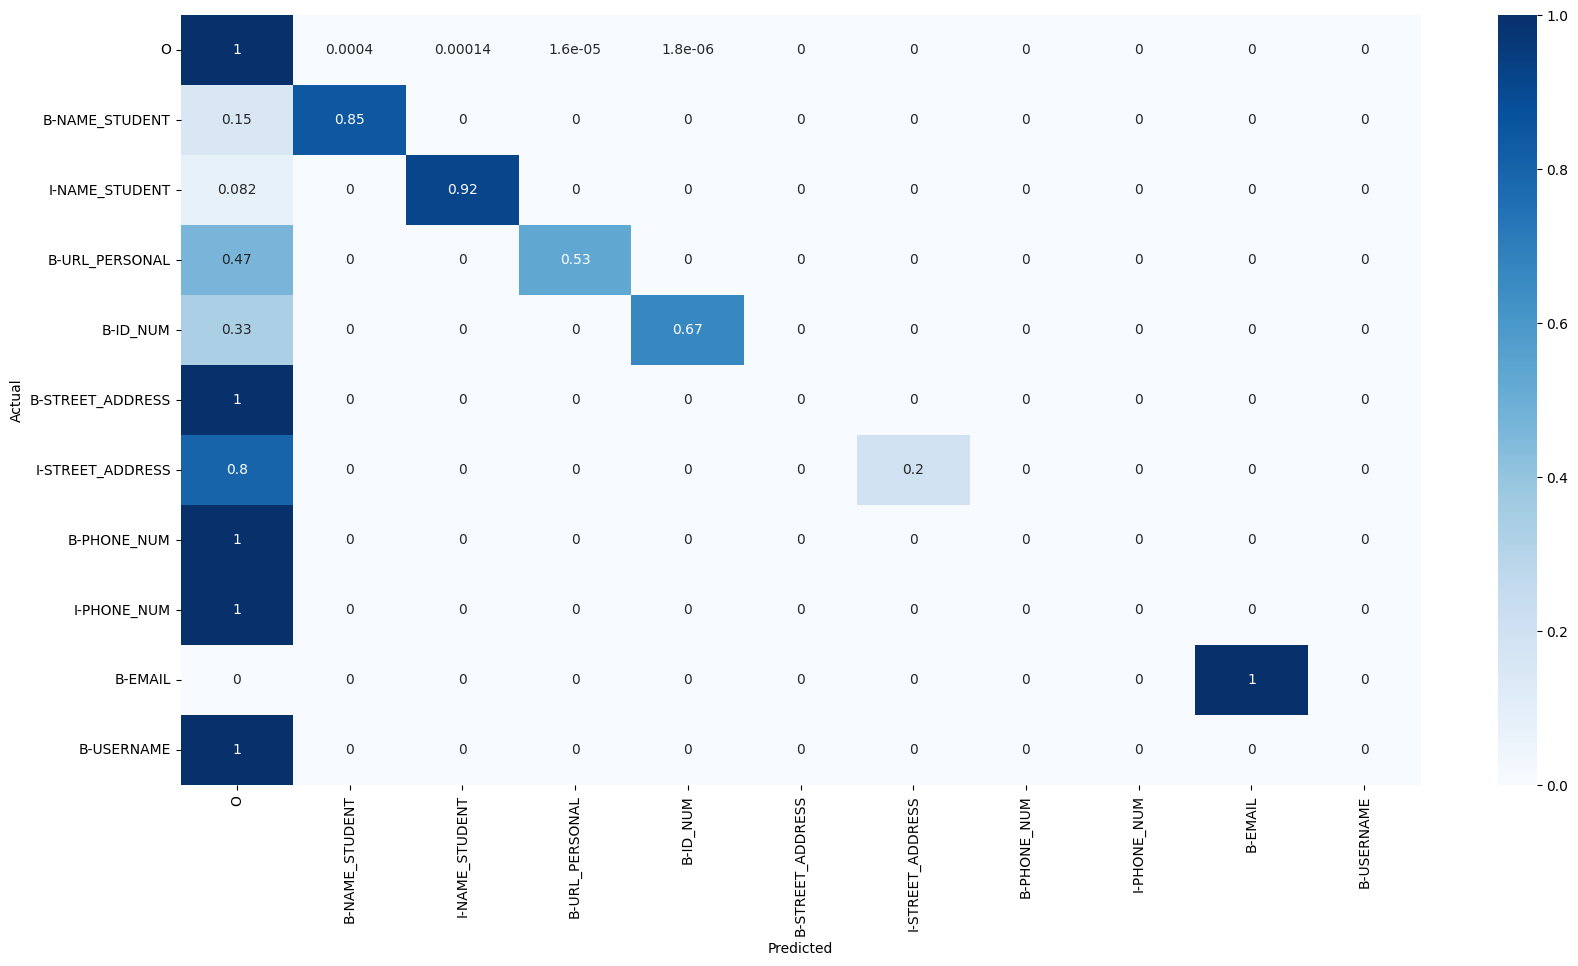

In [147]:
# we create heatmap of our predictions and labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(df_results['labels'], df_results['predictions'], labels=df_results.labels.unique(), normalize='true')
# normalize the confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, vmin=0, cmap='Blues', vmax=1,
            xticklabels=df_results.labels.unique(), yticklabels=df_results.labels.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


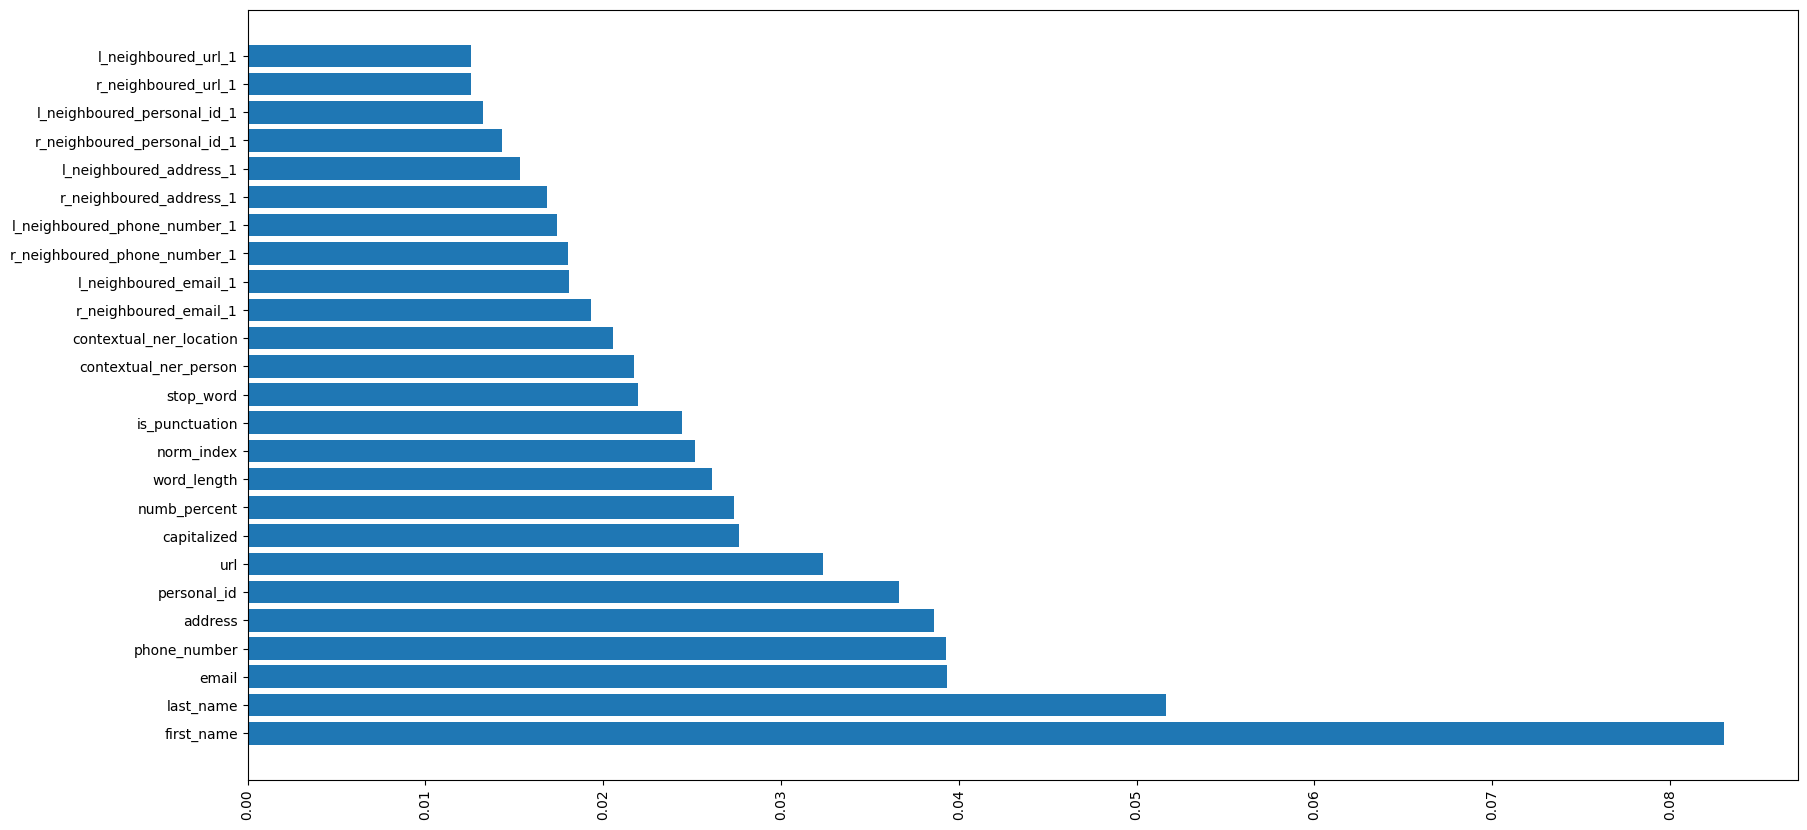

In [146]:
# print feature importance
importances = np.sort(model.feature_importances_)[::-1]
cols = X_train.drop(columns=["token", "labels"]).columns
plt.figure(figsize=(20, 10))
plt.barh(cols[:25], importances[:25])
plt.xticks(rotation=90)
plt.show();

# 6. Conclusion